# Sentiment Analysis in Healthcare (Mistral 7B) on Colab


In [1]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 --index-url https://download.pytorch.org/whl/cu118

!pip install transformers==4.39.3 datasets==2.18.0 accelerate bitsandbytes scikit-learn sentencepiece evaluate matplotlib seaborn --upgrade -q

!pip install transformers datasets torch accelerate bitsandbytes scikit-learn sentencepiece evaluate matplotlib seaborn --upgrade -q
!pip install datasets --upgrade -q
!pip install huggingface_hub --upgrade -q

Found existing installation: torch 2.7.0
Uninstalling torch-2.7.0:
  Successfully uninstalled torch-2.7.0
Found existing installation: torchvision 0.16.2+cu118
Uninstalling torchvision-0.16.2+cu118:
  Successfully uninstalled torchvision-0.16.2+cu118
Found existing installation: torchaudio 2.1.2+cu118
Uninstalling torchaudio-2.1.2+cu118:
  Successfully uninstalled torchaudio-2.1.2+cu118
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.1.2%2Bcu118-cp311-cp311-linux_x86_64.whl (2325.9 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.16.2%2Bcu118-cp311-cp311-linux_x86_64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.1.2%2Bcu118-cp311-cp311-linux_x86_64.whl (3.2 MB)
  Using cached https://download.pytorch.org/whl/triton-2.1.0-0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (89.2 MB)
  Attempting uninstall: triton
    Found existing installation: trit

In [2]:
import time
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from huggingface_hub import login
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model


/usr/local/lib/python3.11/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.11/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
MODEL_NAME            = 'mistralai/Mistral-7B-Instruct-v0.3'
DATASET_NAME          = 'Zakia/drugscom_reviews'
NUM_SAMPLES_FOR_TRAIN = 1000
NUM_SAMPLES_FOR_EVAL  = 1000
MAX_LENGTH            = 256
BATCH_SIZE            = 4
NUM_EPOCHS            = 1

label2id = {'Negative':0, 'Neutral':1, 'Positive':2}
id2label = {v:k for k,v in label2id.items()}

INSTRUCTION = (
    'You are a medical expert. Classify the sentiment of the following patient review '
    'as Positive, Neutral, or Negative.'
)

OUTPUT_DIR_BASE = './base_results'
OUTPUT_DIR_LORA = './lora_results'


In [4]:
from datasets import load_dataset
import pandas as pd

# 1) Load the full dataset
ds = load_dataset("Zakia/drugscom_reviews")

# 2) Turn the training split into a pandas DataFrame
df = pd.DataFrame(ds["train"])

# 3) Look at the raw rating distribution
print("Rating counts:\n", df["rating"].value_counts().sort_index())

# 4) Apply your sentiment‐mapping function
def map_sentiment(r):
    r = float(r)
    if r <= 4:       return "Positive"
    elif r <= 6:     return "Neutral"
    else:            return "Negative"

df["sentiment"] = df["rating"].map(map_sentiment)

# 5) Check how many of each label you actually have
print("\nSentiment counts:\n", df["sentiment"].value_counts())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Rating counts:
 rating
1.0     21619
2.0      6931
3.0      6513
4.0      5012
5.0      8013
6.0      6343
7.0      9456
8.0     18890
9.0     27531
10.0    50989
Name: count, dtype: int64

Sentiment counts:
 sentiment
Negative    106866
Positive     40075
Neutral      14356
Name: count, dtype: int64


In [5]:
from huggingface_hub import login
login()

In [6]:
print('Loading dataset...')
train_ds = load_dataset(DATASET_NAME, split='train').select(range(NUM_SAMPLES_FOR_TRAIN))
eval_ds  = load_dataset(DATASET_NAME, split='test').select(range(NUM_SAMPLES_FOR_EVAL))

def map_and_label(ex):
    r = float(ex['rating'])
    s = 'Positive' if r <= 4 else ('Neutral' if r <= 6 else 'Negative')
    return {'labels': label2id[s]}

train_ds = train_ds.map(map_and_label)
eval_ds  = eval_ds.map(map_and_label)



Loading dataset...


In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def tokenize_and_prepare(batch):
    prompts = [f"{INSTRUCTION}\n\nReview: {r}\nSentiment:" for r in batch['review']]
    toks = tokenizer(prompts, truncation=True, padding='max_length', max_length=MAX_LENGTH)
    toks['labels'] = batch['labels']
    return toks

train_ds = train_ds.map(tokenize_and_prepare, batched=True)
eval_ds  = eval_ds.map(tokenize_and_prepare, batched=True)

keep = {'input_ids','attention_mask','labels'}
train_ds = train_ds.remove_columns([c for c in train_ds.column_names if c not in keep])
eval_ds  = eval_ds.remove_columns([c for c in eval_ds.column_names   if c not in keep])

train_ds.set_format(type='torch', columns=list(keep))
eval_ds.set_format(type='torch', columns=list(keep))

data_collator = DataCollatorWithPadding(tokenizer)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [8]:
def input_prompt(review: str) -> str:
    return f'''<INST>
You are an expert in analyzing sentiment from drug reviews. Classify each review as Positive, Negative, or Neutral.

### Criteria:
- **Positive**: Satisfaction, effectiveness, minimal side effects.
- **Negative**: Dissatisfaction, strong side effects, no relief.
- **Neutral**: Mixed or unclear sentiments.

### Examples:
Review: "This medicine healed me quickly!"  Sentiment: Positive
Review: "No change and I felt worse."      Sentiment: Negative
Review: "It helped but gave me nausea."   Sentiment: Neutral

### Now classify:
Review: "{review}"
Sentiment: '''



=== Base Model Evaluation (8-bit, manual) ===


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at mistralai/Mistral-7B-Instruct-v0.3 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating Base:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc: 0.6550 | Prec: 0.5984 | Rec: 0.6550 | F1: 0.6157

              precision    recall  f1-score   support

           0     0.8645    0.9384    0.8999       666
           1     0.1124    0.3372    0.1686        86
           2     0.0526    0.0040    0.0075       248

    accuracy                         0.6550      1000
   macro avg     0.3432    0.4266    0.3587      1000
weighted avg     0.5984    0.6550    0.6157      1000

Raw CM:
 [[625  27  14]
 [ 53  29   4]
 [ 45 202   1]]


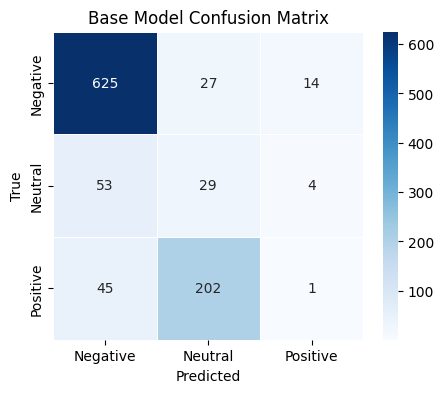

In [9]:
# ==== Base Model Evaluation (8-bit, manual) ====
print("\n=== Base Model Evaluation (8-bit, manual) ===")

bnb_conf = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_enable_fp32_cpu_offload=True,
)
model_base = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_conf,
    num_labels=len(label2id),
    device_map="auto",
)
model_base.config.pad_token_id = tokenizer.pad_token_id
model_base.eval()
device = model_base.device

from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# keep batch_size=1 to minimize peak memory
eval_loader = DataLoader(eval_ds, batch_size=1, collate_fn=data_collator)

all_preds, all_labels = [], []
for batch in tqdm(eval_loader, desc="Evaluating Base"):
    labels = batch["labels"].numpy()
    inputs = {k: v.to(device) for k,v in batch.items() if k in ("input_ids","attention_mask")}
    with torch.no_grad():
        logits = model_base(**inputs).logits
    preds = logits.argmax(-1).cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(labels)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

print(f"Acc: {accuracy_score(all_labels,all_preds):.4f} | "
      f"Prec: {precision_score(all_labels,all_preds,average='weighted'):.4f} | "
      f"Rec: {recall_score(all_labels,all_preds,average='weighted'):.4f} | "
      f"F1: {f1_score(all_labels,all_preds,average='weighted'):.4f}\n")

print(classification_report(all_labels, all_preds, digits=4))
cm_base = confusion_matrix(all_labels, all_preds)
print("Raw CM:\n", cm_base)

import matplotlib.pyplot as plt, seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_base,
    annot=True,
    fmt="d",
    cmap="Blues",               # ← use a pure blue palette
    cbar=True,
    linewidths=0.5,             # subtle grid lines
    xticklabels=list(label2id.keys()),
    yticklabels=list(label2id.keys())
)

plt.title("Base Model Confusion Matrix")
plt.ylabel("True"); plt.xlabel("Predicted")
plt.show()


Measuring Base Latency:   0%|          | 0/1000 [00:00<?, ?it/s]

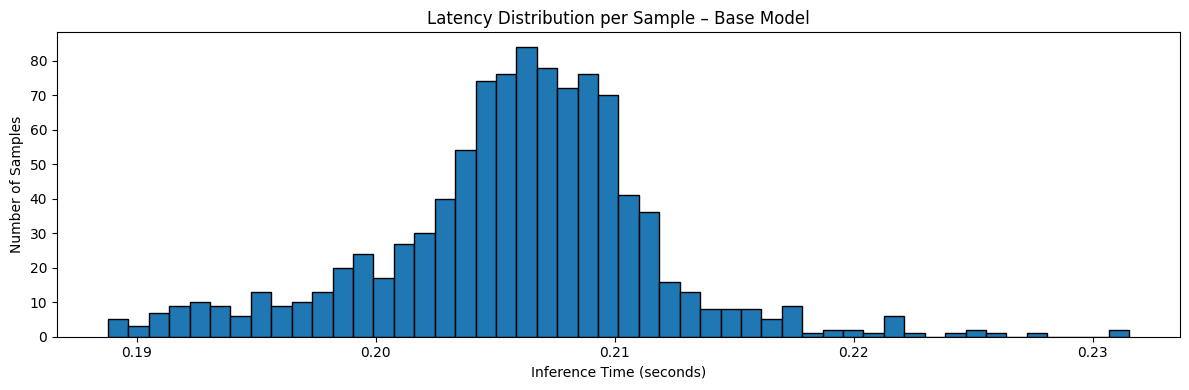

In [10]:
# ─── Full Eval Latency: Base Model ────────────────────────────────────────
import time
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# 0) Create a 1-sample DataLoader over your eval_ds
eval_loader = DataLoader(eval_ds, batch_size=1, collate_fn=data_collator)

latencies_base = []
for batch in tqdm(eval_loader, desc="Measuring Base Latency"):
    # move inputs to GPU
    inputs = {k: v.to(device) for k,v in batch.items() if k in ("input_ids","attention_mask")}
    torch.cuda.synchronize()                          # wait for any prior work
    start = time.time()                               # start timer
    with torch.no_grad():
        _ = model_base(**inputs).logits               # forward pass
    torch.cuda.synchronize()                          # wait for this pass
    latencies_base.append(time.time() - start)        # record elapsed

# 1) Plot exactly like your example
plt.figure(figsize=(12,4))                           # very wide figure
plt.hist(
    latencies_base,
    bins=50,                                         # fine granularity
    edgecolor="k"                                    # black bar edges
)
plt.title("Latency Distribution per Sample – Base Model")
plt.xlabel("Inference Time (seconds)")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at mistralai/Mistral-7B-Instruct-v0.3 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-c6abf2727660>:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed expl

Step,Training Loss
50,1.112300
100,0.675300



=== Evaluation Metrics ===
eval_loss: 0.4083
eval_accuracy: 0.8390
eval_precision: 0.8047
eval_recall: 0.8390
eval_f1: 0.8167
eval_runtime: 39.5359
eval_samples_per_second: 25.2930
eval_steps_per_second: 3.1620
epoch: 1.0000

--- Classification Report ---
              precision    recall  f1-score   support

    Negative     0.8860    0.9339    0.9094       666
     Neutral     0.2692    0.0814    0.1250        86
    Positive     0.7721    0.8468    0.8077       248

    accuracy                         0.8390      1000
   macro avg     0.6424    0.6207    0.6140      1000
weighted avg     0.8047    0.8390    0.8167      1000


Confusion Matrix:
 [[622  11  33]
 [ 50   7  29]
 [ 30   8 210]]


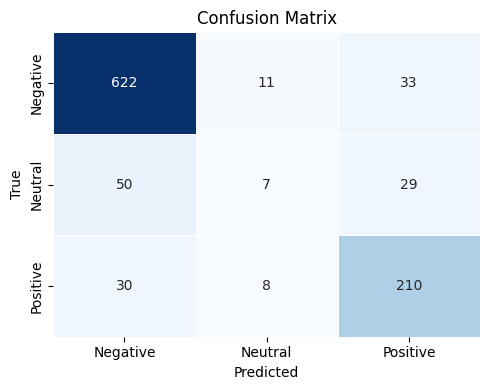

In [11]:
# ─── LoRA Fine-Tuning (fixed quant config) ───────────────────────────────────



#  Load a pure 4-bit model on GPU (no offload)
bnb_conf_train = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_enable_fp32_cpu_offload=False,  # ← turn OFF offloading during training
    offload_buffers=False
)
model_train = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_conf_train,
    num_labels=len(label2id),
    device_map="auto",
)
model_train.config.pad_token_id = tokenizer.pad_token_id

#  Prepare for k-bit (LoRA) training
model_train.gradient_checkpointing_enable()
model_kbit = prepare_model_for_kbit_training(model_train)

#  Attach LoRA adapters
lora_conf = LoraConfig(
    r=4,
    lora_alpha=8,
    target_modules=["q_proj","v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS",
)
model_lora = get_peft_model(model_kbit, lora_conf)

#  Trainer (keep batch=1, grad_accum=8)
training_args = TrainingArguments(
    output_dir="./lora_results",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    bf16=torch.cuda.is_available(),
    logging_steps=50,
    save_strategy="epoch",
    report_to="none",
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted", zero_division=0),
        "recall": recall_score(labels, preds, average="weighted", zero_division=0),
        "f1": f1_score(labels, preds, average="weighted", zero_division=0),
    }

trainer = Trainer(
    model=model_lora,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,      # ← optional, but supported
)


#  Fine-tune!
trainer.train()

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Evaluate via Trainer.evaluate()
eval_metrics = trainer.evaluate(eval_dataset=eval_ds, metric_key_prefix="eval")
print("\n=== Evaluation Metrics ===")
for k,v in eval_metrics.items():
    print(f"{k}: {v:.4f}")

# 2) Get raw predictions and labels
preds = trainer.predict(eval_ds).predictions.argmax(-1)
labels = eval_ds["labels"]

# 3) Classification report
print("\n--- Classification Report ---")
print(classification_report(labels, preds, digits=4, target_names=list(label2id.keys())))

# 4) Confusion matrix
cm = confusion_matrix(labels, preds)
print("\nConfusion Matrix:\n", cm)

# 5) Plot heatmap
plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label2id.keys()),
    yticklabels=list(label2id.keys()),
    cbar=False,
    linewidths=0.5
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()



Measuring LoRA Latency:   0%|          | 0/1000 [00:00<?, ?it/s]

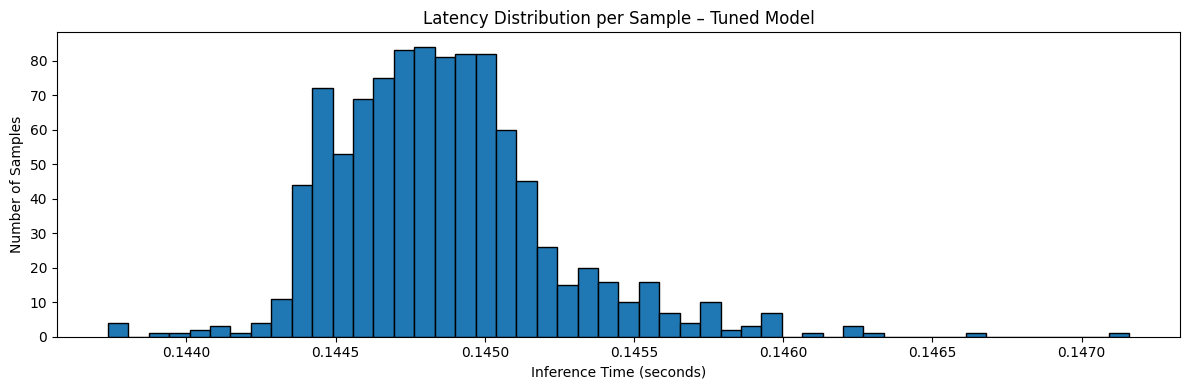

In [12]:
# ─── Full Eval Latency: LoRA‐Tuned Model ─────────────────────────────────
latencies_lora = []
for batch in tqdm(eval_loader, desc="Measuring LoRA Latency"):
    inputs = {k: v.to(device) for k,v in batch.items() if k in ("input_ids","attention_mask")}
    torch.cuda.synchronize()
    start = time.time()
    with torch.no_grad():
        _ = model_lora(**inputs).logits
    torch.cuda.synchronize()
    latencies_lora.append(time.time() - start)

plt.figure(figsize=(12,4))
plt.hist(
    latencies_lora,
    bins=50,
    edgecolor="k"
)
plt.title("Latency Distribution per Sample – Tuned Model")
plt.xlabel("Inference Time (seconds)")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()


In [19]:
#  Install Gradio (if needed)
!pip install gradio -q

#  Imports
import gradio as gr
import torch
from collections import OrderedDict

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_lora.to(DEVICE)

# Inference function
def predict_sentiment(review: str, which_model: str):
    # pick the correct model
    model = model_lora if which_model=="Fine-tuned (LoRA)" else model_base

    # build your prompt + tokenize
    prompt = input_prompt(review)
    toks = tokenizer(
        prompt,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="pt"
    ).to(DEVICE)

    # forward pass
    model.eval()
    with torch.no_grad():
        logits = model(**toks).logits

    # compute softmax
    probs = torch.softmax(logits, dim=-1)[0].cpu().numpy()

    # return in fixed order
    return OrderedDict([
        ("Negative", float(probs[label2id["Negative"]])),
        ("Neutral",  float(probs[label2id["Neutral"]])),
        ("Positive", float(probs[label2id["Positive"]]))
    ])

# Gradio interface
iface = gr.Interface(
    fn=predict_sentiment,
    inputs=[
        gr.Textbox(
            lines=5,
            placeholder="Type a drug review here…",
            label="Patient Review"
        )
    ],
    outputs=gr.Label(
        num_top_classes=3,
        label="Predicted Sentiment & Confidence"
    ),
    title="Healthcare Review Sentiment Classifier",
    description=(
        "Enter a drug review and click Submit to see whether it's "
        "**Negative**, **Neutral**, or **Positive**, with confidence scores."
    ),
)

iface.launch(share=True, debug=True)


/usr/local/lib/python3.11/dist-packages/gradio/utils.py:1023: UserWarning: Expected 2 arguments for function <function predict_sentiment at 0x7b07dc0f0fe0>, received 1.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gradio/utils.py:1027: UserWarning: Expected at least 2 arguments for function <function predict_sentiment at 0x7b07dc0f0fe0>, received 1.
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://4004f09c8eb1ea8784.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.11/dist-packages/gradio/helpers.py:977: UserWarning: Unexpected argument. Filling with None.
  warnings.warn("Unexpected argument. Filling with None.")


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7861 <> https://4004f09c8eb1ea8784.gradio.live
